In [ ]:
pip install ultralytics

In [ ]:
import glob
import os
import matplotlib.pyplot as plt
import cv2 as cv
from ultralytics import YOLO
import random
import numpy as np
import tensorflow as tf

In [3]:
import wandb
wandb.init(mode='disabled')

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nimapourmoradi/persian-car-plates-digits-detection-yolov8")

print("Path to dataset files:", path)

100%|██████████| 6.73M/6.73M [00:00<00:00, 33.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nimapourmoradi/persian-car-plates-digits-detection-yolov8/versions/4


In [5]:
train_path = "/root/.cache/kagglehub/datasets/nimapourmoradi/persian-car-plates-digits-detection-yolov8/versions/4/Persian_Plates_Digits_YOLOV8_V2/train"
val_path = "/root/.cache/kagglehub/datasets/nimapourmoradi/persian-car-plates-digits-detection-yolov8/versions/4/Persian_Plates_Digits_YOLOV8_V2/valid"
test_path = "/root/.cache/kagglehub/datasets/nimapourmoradi/persian-car-plates-digits-detection-yolov8/versions/4/Persian_Plates_Digits_YOLOV8_V2/test"

def count_images_and_labels(path):
  images = glob.glob(os.path.join(path + '/images' , '*.jpg'))
  labels = glob.glob(os.path.join(path + '/labels' , '*.txt'))
  return len(images) , len(labels)

train_images_count, train_labels_count = count_images_and_labels(train_path)
val_images_count, val_labels_count = count_images_and_labels(val_path)
test_images_count, test_labels_count = count_images_and_labels(test_path)

print('the number of train_images : {} , the number of train_labels : {}'.format(train_images_count , train_labels_count))
print('the number of validation_images : {} , the number of validation_labels : {}'.format(val_images_count , val_labels_count))
print('the number of test_images : {} , the number of test_labels : {}'.format(test_images_count , test_labels_count))

print('the number of all images and labels : {}'.format(train_images_count + val_images_count + test_images_count))

the number of train_images : 1203 , the number of train_labels : 1203
the number of validation_images : 115 , the number of validation_labels : 115
the number of test_images : 57 , the number of test_labels : 57
the number of all images and labels : 1375


In [6]:
def Image_Size(train_images) :
    img_sizes = set()

    for img_name in os.listdir(train_images):
        img_path = os.path.join(train_images, img_name)
        img = cv.imread(img_path)
        h, w, c = img.shape
        img_sizes.add((h, w))

    return img_sizes

image_sizes = Image_Size(train_path + '/images')

if len(image_sizes) == 1:
  print('all the images have a same size : {}'.format(image_sizes))
else:
  print('all the images do not have a same size')

all the images have a same size : {(70, 200)}


In [7]:
H = list(image_sizes)[0][0]
W = list(image_sizes)[0][1]

print('the height of the images is : {} and the width of the images is : {}'.format(H,W))

the height of the images is : 70 and the width of the images is : 200


In [8]:
classes_dict =  {
            '0':'0',
            '1':'1',
            '2':'2',
            '3':'3',
            '4':'4',
            '5':'5',
            '6':'6',
            '7':'7',
            '8':'8',
            '9':'9',
            '10':'B',
            '11':'C',
            '12':'D',
            '13':'G',
            '14':'H',
            '15':'J',
            '16':'L',
            '17':'M',
            '18':'N',
            '19':'S',
            '20':'T',
            '21':'V',
            '22':'Y'
            }

In [9]:
def draw_bbox(image , bboxes):
  for i in range(len(bboxes)):
    b = bboxes[i]
    b = b.split()

    label = classes_dict[b[0]]

    x_center = float(b[1]) * W
    y_center = float(b[2]) * H
    w = float(b[3]) * W
    h = float(b[4]) * H

    x_center , y_center , w , h = int(x_center) , int(y_center) , int(w) , int(h)

    cv.rectangle(image , (x_center - w // 2 , y_center - h // 2) , (x_center + w // 2 , y_center + h // 2) , (255,0,0) , 1)
    cv.putText(image, label, (x_center - w // 2 , (y_center - h // 2) + 10), cv.FONT_HERSHEY_COMPLEX, 0.35, (0, 255, 255), 1, cv.LINE_AA)

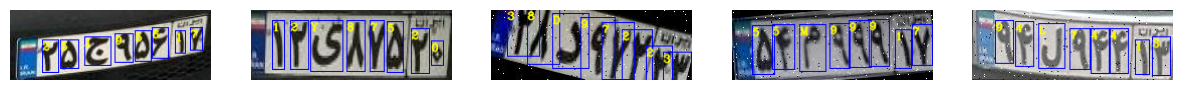

In [10]:
def plot_random_images(image_path , label_path , n=5):
  images = sorted(glob.glob(os.path.join(image_path  , '*.jpg')))
  labels = sorted(glob.glob(os.path.join(label_path  , '*.txt')))
  random_indices = random.sample(range(len(images)) , 5)
  random_images = [images[i] for i in random_indices]
  random_labels = [labels[i] for i in random_indices]

  plt.figure(figsize=(15,15))
  for i , image in enumerate(random_images):
    img = cv.imread(image)
    bboxes = open(random_labels[i])
    bboxes = bboxes.readlines()
    draw_bbox(img , bboxes)
    plt.subplot(1 , n , i+1)
    plt.imshow(img[...,::-1])
    plt.axis('off')
  plt.show()

plot_random_images(train_path + '/images' , train_path + '/labels')

In [ ]:
import os
import cv2 as cv
import glob
import tensorflow as tf
import numpy as np


image_folder = os.path.join(train_path, 'images')  

def augment(image):
    image = tf.image.random_brightness(image, max_delta=0.2) 
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)  
    image = tf.image.random_hue(image, max_delta=0.2)  
    return image

for img_path in glob.glob(os.path.join(image_folder, '*.jpg')):  
    image = cv.imread(img_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    image_tensor = tf.expand_dims(image_tensor, 0)  

    augmented_image_tensor = augment(image_tensor)

    augmented_image = tf.squeeze(augmented_image_tensor).numpy().astype(np.uint8)

    augmented_image_bgr = cv.cvtColor(augmented_image, cv.COLOR_RGB2BGR)  
    cv.imwrite(img_path, augmented_image_bgr)  

print("All images were replaced successfully")

In [ ]:
import os

labels_folder = '/root/.cache/kagglehub/datasets/nimapourmoradi/persian-car-plates-digits-detection-yolov8/versions/4/Persian_Plates_Digits_YOLOV8_V2/train/labels'  # این مسیر را به پوشه موردنظر تغییر دهید

label_files = os.listdir(labels_folder)

for file_name in label_files:
    if file_name.endswith('.txt'):
        old_file_path = os.path.join(labels_folder, file_name)
        new_file_path = os.path.join(labels_folder, file_name)
        os.rename(old_file_path, new_file_path)

print("All label files were successfully renamed")

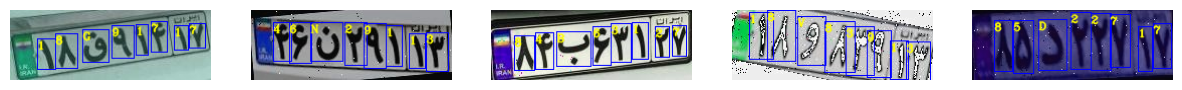

In [14]:
plot_random_images(train_path + '/images' , train_path + '/labels')

In [15]:
data_yaml_path = os.path.join('/root/.cache/kagglehub/datasets/nimapourmoradi/persian-car-plates-digits-detection-yolov8/versions/4/Persian_Plates_Digits_YOLOV8_V2/data.yaml')
digits_detector_model = YOLO('yolov8s.yaml').load('yolov8s.pt')

result = digits_detector_model.train(data=data_yaml_path , epochs=50 , amp=False)

100%|██████████| 21.5M/21.5M [00:00<00:00, 199MB/s]


Transferred 355/355 items from pretrained weights
Ultralytics 8.3.21 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/root/.cache/kagglehub/datasets/nimapourmoradi/persian-car-plates-digits-detection-yolov8/versions/4/Persian_Plates_Digits_YOLOV8_V2/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=yolov8s.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=Fal

100%|██████████| 755k/755k [00:00<00:00, 20.3MB/s]


Overriding model.yaml nc=80 with nc=23

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

train: Scanning /root/.cache/kagglehub/datasets/nimapourmoradi/persian-car-plates-digits-detection-yolov8/versions/4/Persian_Plates_Digits_YOLOV8_V2/train/labels... 1203 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1203/1203 [00:00<00:00, 1479.54it/s]


train: New cache created: /root/.cache/kagglehub/datasets/nimapourmoradi/persian-car-plates-digits-detection-yolov8/versions/4/Persian_Plates_Digits_YOLOV8_V2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.19 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /root/.cache/kagglehub/datasets/nimapourmoradi/persian-car-plates-digits-detection-yolov8/versions/4/Persian_Plates_Digits_YOLOV8_V2/valid/labels... 115 images, 0 backgrounds, 0 corrupt: 100%|██████████| 115/115 [00:00<00:00, 777.77it/s]

val: New cache created: /root/.cache/kagglehub/datasets/nimapourmoradi/persian-car-plates-digits-detection-yolov8/versions/4/Persian_Plates_Digits_YOLOV8_V2/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00037, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.03G      1.488      2.568      1.337         79        640: 100%|██████████| 76/76 [00:43<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        115        918      0.768      0.615      0.731      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.76G       1.15      0.991       1.12         47        640: 100%|██████████| 76/76 [00:41<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]

                   all        115        918      0.902      0.945      0.962      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.74G      1.069     0.7764      1.078         70        640: 100%|██████████| 76/76 [00:42<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]

                   all        115        918      0.934      0.978      0.981      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.73G      1.046     0.7089       1.07         61        640: 100%|██████████| 76/76 [00:43<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


                   all        115        918      0.965      0.987      0.983      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.81G      1.014     0.6539      1.051         55        640: 100%|██████████| 76/76 [00:42<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.85it/s]

                   all        115        918      0.957      0.985      0.984      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.74G     0.9815     0.5986      1.038         78        640: 100%|██████████| 76/76 [00:42<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]

                   all        115        918      0.967      0.977      0.984      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.74G     0.9699      0.577      1.032         57        640: 100%|██████████| 76/76 [00:42<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]

                   all        115        918      0.965      0.983      0.982      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.75G     0.9504     0.5619      1.025         66        640: 100%|██████████| 76/76 [00:42<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


                   all        115        918      0.966       0.98      0.984      0.757

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.74G      0.929     0.5542      1.019         45        640: 100%|██████████| 76/76 [00:42<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.89it/s]

                   all        115        918      0.966      0.987      0.984      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.81G     0.9394     0.5384      1.023         41        640: 100%|██████████| 76/76 [00:42<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.83it/s]

                   all        115        918      0.961      0.983      0.984      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.65G     0.9256     0.5284      1.018         48        640: 100%|██████████| 76/76 [00:42<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


                   all        115        918       0.95      0.987      0.985      0.759

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.78G     0.9082     0.5256       1.01         48        640: 100%|██████████| 76/76 [00:42<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


                   all        115        918      0.966       0.99      0.984      0.755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.76G     0.8907     0.5038      1.004         50        640: 100%|██████████| 76/76 [00:42<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]

                   all        115        918      0.976      0.989      0.985      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.76G     0.8932     0.5013      1.004         61        640: 100%|██████████| 76/76 [00:42<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.85it/s]

                   all        115        918      0.967      0.985      0.985      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.76G     0.8921     0.4953      1.003         59        640: 100%|██████████| 76/76 [00:42<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


                   all        115        918      0.973      0.983      0.983      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.78G     0.8742     0.4798      1.003         25        640: 100%|██████████| 76/76 [00:42<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]


                   all        115        918      0.964      0.987      0.984      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.75G     0.8674     0.4767     0.9923         47        640: 100%|██████████| 76/76 [00:42<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.92it/s]

                   all        115        918      0.974      0.983      0.983      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.77G     0.8636     0.4657     0.9912         47        640: 100%|██████████| 76/76 [00:42<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.94it/s]

                   all        115        918      0.973      0.987      0.982       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.74G     0.8509     0.4667     0.9905         46        640: 100%|██████████| 76/76 [00:42<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


                   all        115        918      0.974      0.984      0.984      0.753

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.74G     0.8432     0.4588     0.9848         53        640: 100%|██████████| 76/76 [00:42<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]

                   all        115        918      0.975      0.979      0.984       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.75G     0.8367     0.4533     0.9866         53        640: 100%|██████████| 76/76 [00:42<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.88it/s]

                   all        115        918      0.972      0.978      0.984      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.74G     0.8316     0.4413     0.9777         58        640: 100%|██████████| 76/76 [00:42<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        115        918      0.965      0.981      0.984      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.75G     0.8208     0.4325     0.9742         79        640: 100%|██████████| 76/76 [00:42<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        115        918      0.951      0.983      0.983      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.74G     0.8059      0.426     0.9691         44        640: 100%|██████████| 76/76 [00:42<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.90it/s]

                   all        115        918      0.969      0.986      0.984      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.77G      0.805     0.4257     0.9673         41        640: 100%|██████████| 76/76 [00:42<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]

                   all        115        918      0.961      0.983      0.984      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.77G     0.7925     0.4144     0.9662         73        640: 100%|██████████| 76/76 [00:42<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


                   all        115        918      0.971      0.977      0.982      0.755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.74G     0.7879     0.4162     0.9631         35        640: 100%|██████████| 76/76 [00:42<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


                   all        115        918      0.966      0.983      0.984       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.64G     0.7877     0.4088      0.961         60        640: 100%|██████████| 76/76 [00:42<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.88it/s]

                   all        115        918      0.968      0.978      0.983      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.77G     0.7736     0.3985     0.9562         39        640: 100%|██████████| 76/76 [00:42<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.84it/s]

                   all        115        918      0.961       0.98      0.981      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.75G     0.7741     0.4046     0.9549         82        640: 100%|██████████| 76/76 [00:42<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

                   all        115        918      0.969      0.975      0.984      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.73G     0.7592     0.3855     0.9507         72        640: 100%|██████████| 76/76 [00:42<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]

                   all        115        918      0.973      0.985      0.983      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.75G     0.7534     0.3836     0.9473         37        640: 100%|██████████| 76/76 [00:42<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all        115        918      0.974      0.983      0.984       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.73G     0.7409     0.3781     0.9492         53        640: 100%|██████████| 76/76 [00:42<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


                   all        115        918      0.969      0.984      0.982      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.75G     0.7404      0.381     0.9488         51        640: 100%|██████████| 76/76 [00:42<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.87it/s]

                   all        115        918      0.962      0.983      0.982      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.73G     0.7312     0.3757     0.9439         40        640: 100%|██████████| 76/76 [00:42<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]

                   all        115        918      0.964      0.987      0.983      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.81G     0.7289     0.3705     0.9437         50        640: 100%|██████████| 76/76 [00:42<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


                   all        115        918      0.969      0.984      0.983      0.757

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.74G      0.714     0.3598      0.935         61        640: 100%|██████████| 76/76 [00:42<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


                   all        115        918       0.96      0.982      0.982      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.61G     0.7085     0.3592     0.9381         46        640: 100%|██████████| 76/76 [00:42<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.96it/s]

                   all        115        918      0.971      0.981      0.982      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.77G     0.6997     0.3605     0.9302         55        640: 100%|██████████| 76/76 [00:42<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

                   all        115        918      0.966      0.979      0.984       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.74G     0.6974     0.3538     0.9314         41        640: 100%|██████████| 76/76 [00:42<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


                   all        115        918      0.973      0.985      0.983      0.753
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.86G     0.6816     0.3065     0.9341         23        640: 100%|██████████| 76/76 [00:42<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]


                   all        115        918       0.97      0.985      0.983      0.766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.62G     0.6452     0.2835     0.9185         24        640: 100%|██████████| 76/76 [00:42<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]

                   all        115        918      0.972      0.968      0.983      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.62G     0.6349     0.2827     0.9189         24        640: 100%|██████████| 76/76 [00:42<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.99it/s]

                   all        115        918      0.954      0.986      0.983      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.62G     0.6238     0.2756     0.9072         24        640: 100%|██████████| 76/76 [00:42<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]

                   all        115        918       0.96      0.983      0.983      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.62G     0.6161     0.2721     0.9065         21        640: 100%|██████████| 76/76 [00:42<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.95it/s]

                   all        115        918      0.966      0.982      0.984      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.62G     0.6054     0.2662     0.9008         24        640: 100%|██████████| 76/76 [00:42<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


                   all        115        918      0.957       0.98      0.983      0.759

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.62G     0.5984     0.2665     0.9008         23        640: 100%|██████████| 76/76 [00:41<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]

                   all        115        918      0.967      0.981      0.984      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.62G     0.5938     0.2638     0.8997         23        640: 100%|██████████| 76/76 [00:42<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.92it/s]

                   all        115        918      0.971      0.982      0.983      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.62G     0.5835     0.2581      0.898         23        640: 100%|██████████| 76/76 [00:42<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.58it/s]

                   all        115        918      0.966      0.983      0.984       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.62G      0.579     0.2563       0.89         23        640: 100%|██████████| 76/76 [00:42<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.96it/s]

                   all        115        918      0.964      0.984      0.983      0.761



50 epochs completed in 0.621 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.21 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11,134,485 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


                   all        115        918       0.97      0.985      0.983      0.766
                     0         14         14          1      0.915      0.995      0.677
                     1         90        135      0.982      0.993       0.98      0.691
                     2         62         83      0.945      0.964      0.963      0.771
                     3         74        111       0.98      0.928       0.95      0.753
                     4         42         54      0.958          1       0.98      0.762
                     5         61         82          1      0.995      0.995      0.784
                     6         51         62      0.964          1      0.982      0.759
                     7         77        112      0.991      0.988      0.994      0.766
                     8         58         72      0.973      0.999       0.97      0.737
                     9         54         78      0.984      0.949      0.965      0.761
                     

In [16]:
best_model_path = os.path.join('/content/runs/detect/train/weights/best.pt')
best_model_digits = YOLO(best_model_path)

In [17]:
result_test = best_model_digits.val()

Ultralytics 8.3.21 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11,134,485 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /root/.cache/kagglehub/datasets/nimapourmoradi/persian-car-plates-digits-detection-yolov8/versions/4/Persian_Plates_Digits_YOLOV8_V2/valid/labels.cache... 115 images, 0 backgrounds, 0 corrupt: 100%|██████████| 115/115 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]


                   all        115        918       0.97      0.985      0.983      0.766
                     0         14         14          1      0.915      0.995      0.677
                     1         90        135      0.982      0.993       0.98      0.691
                     2         62         83      0.945      0.964      0.963      0.771
                     3         74        111       0.98      0.928       0.95      0.753
                     4         42         54      0.958          1       0.98      0.762
                     5         61         82          1      0.995      0.995      0.784
                     6         51         62      0.964          1      0.982      0.759
                     7         77        112      0.991      0.988      0.994      0.766
                     8         58         72      0.973      0.999       0.97      0.737
                     9         54         78      0.984      0.949      0.965      0.761
                     

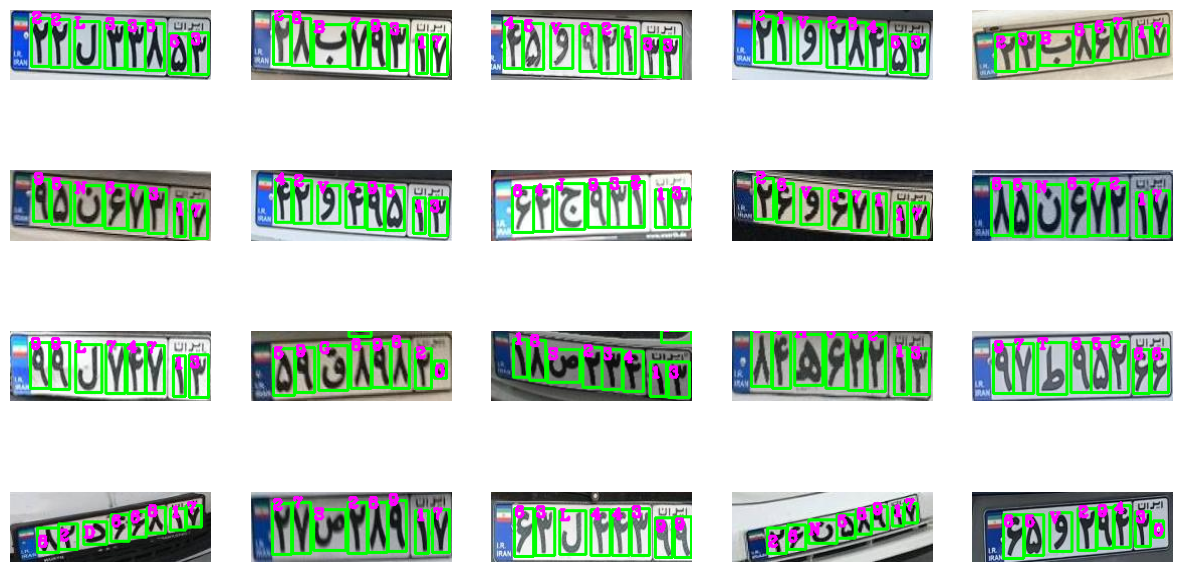

In [18]:
images = sorted(glob.glob(os.path.join(test_path + '/images' , '*.jpg')))
labels = sorted(glob.glob(os.path.join(test_path + '/labels' , '*.txt')))
random_indices = random.sample(range(len(images)) , 20)
random_images = [images[i] for i in random_indices]
random_labels = [labels[i] for i in random_indices]

plt.figure(figsize=(15,8))
for i , image in enumerate(random_images):
  img = cv.imread(image)
  predicted_points = best_model_digits(image , verbose=False)
  for r in predicted_points:
    boxes = r.boxes
    for box in boxes:
      x1, y1, x2, y2 = box.xyxy[0]
      x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
      cv.rectangle(img, (x1, y1) ,(x2, y2), (0, 255, 0), 2)
      cls = int(box.cls[0])
      cv.putText(img , classes_dict[str(cls)] , (x1 , y1 + (y1 // 2)) , cv.FONT_HERSHEY_COMPLEX , 0.5 , (255,0,255) , 2)

  plt.subplot(4 , 5 , i+1)
  plt.imshow(img[...,::-1])
  plt.axis('off')
plt.show()

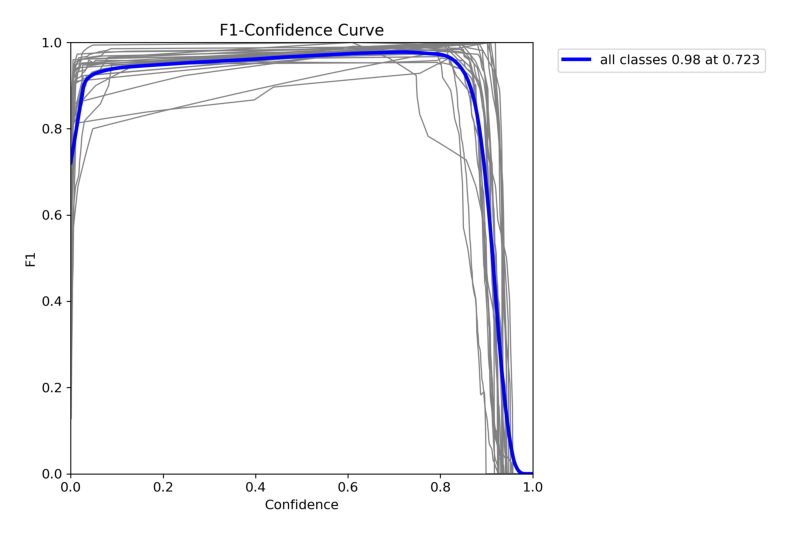

In [31]:
plt.figure(figsize=(10,10))
image_1 = cv.imread('/content/runs/detect/train/F1_curve.png')
plt.imshow(image_1[...,::-1])
plt.axis('off');

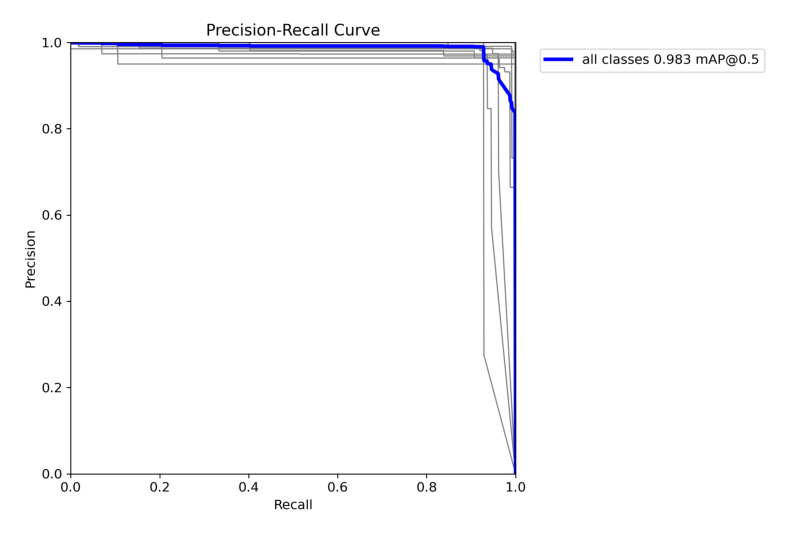

In [32]:
plt.figure(figsize=(10,10))
image_2 = cv.imread('/content/runs/detect/train/PR_curve.png')
plt.imshow(image_2[...,::-1])
plt.axis('off');

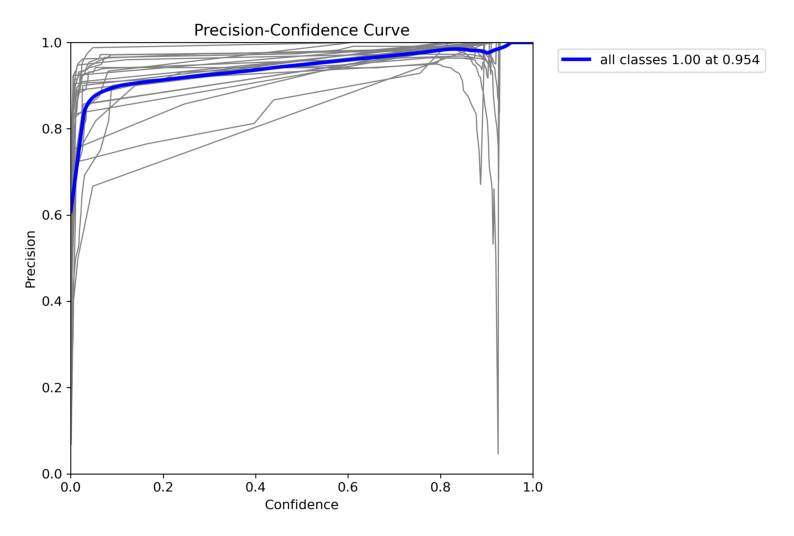

In [36]:
plt.figure(figsize=(10,10))
image_3 = cv.imread('/content/runs/detect/train/P_curve.png')
plt.imshow(image_3[...,::-1])
plt.axis('off');

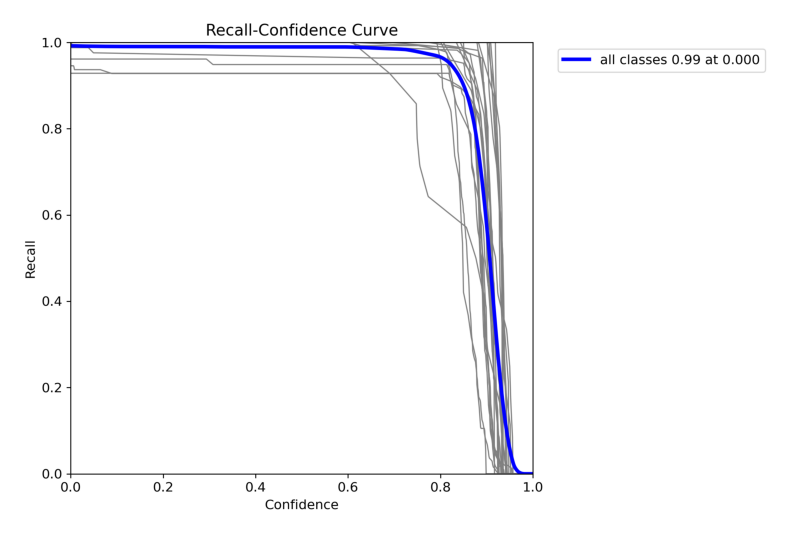

In [37]:
plt.figure(figsize=(10,10))
image_4 = cv.imread('/content/runs/detect/train/R_curve.png')
plt.imshow(image_4[...,::-1])
plt.axis('off');

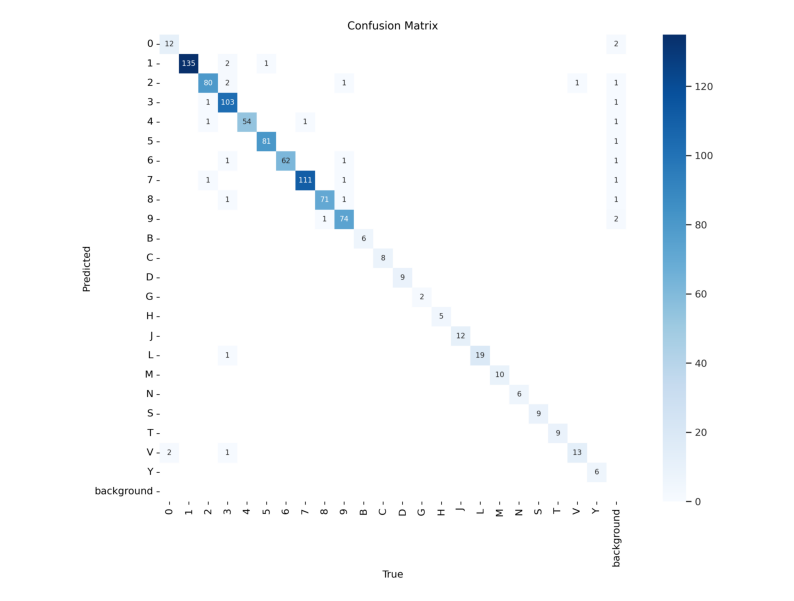

In [38]:
plt.figure(figsize=(10,10))
image_5 = cv.imread('/content/runs/detect/train/confusion_matrix.png')
plt.imshow(image_5[...,::-1])
plt.axis('off');

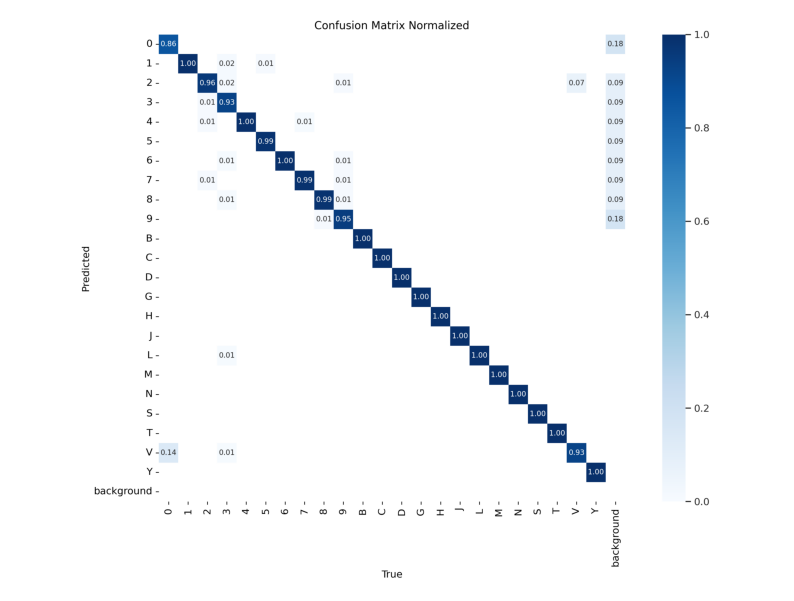

In [40]:
plt.figure(figsize=(10,10))
image_6 = cv.imread('/content/runs/detect/train/confusion_matrix_normalized.png')
plt.imshow(image_6[...,::-1])
plt.axis('off');

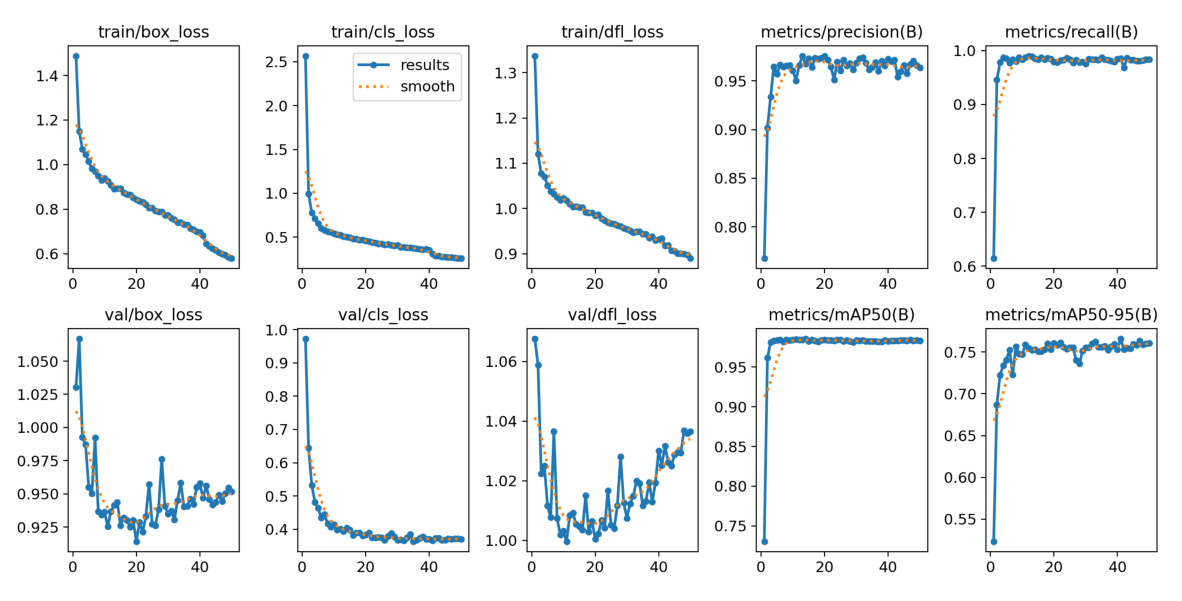

In [43]:
plt.figure(figsize=(15,10))
image_7 = cv.imread('/content/runs/detect/train/results.png')
plt.imshow(image_7[...,::-1])
plt.axis('off');

In [44]:
import pandas as pd
data = pd.read_csv('/content/runs/detect/train/results.csv')
data

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,52.3852,1.48834,2.56825,1.33701,0.76759,0.61456,0.73058,0.52341,1.03043,0.97250,1.06756,0.000122,0.000122,0.000122
1,2,96.8346,1.15047,0.99103,1.11985,0.90178,0.94536,0.96171,0.68667,1.06680,0.64423,1.05881,0.000240,0.000240,0.000240
2,3,141.0530,1.06941,0.77644,1.07751,0.93359,0.97779,0.98142,0.72240,0.99279,0.53203,1.02232,0.000354,0.000354,0.000354
3,4,186.1850,1.04626,0.70893,1.07018,0.96473,0.98692,0.98284,0.73379,0.98707,0.48183,1.02489,0.000348,0.000348,0.000348
4,5,230.7040,1.01387,0.65392,1.05086,0.95721,0.98543,0.98369,0.74061,0.95516,0.46435,1.01171,0.000341,0.000341,0.000341
5,6,275.4480,0.98146,0.59857,1.03781,0.96678,0.97729,0.98419,0.75260,0.95032,0.43402,1.00766,0.000333,0.000333,0.000333
6,7,319.9760,0.96989,0.57698,1.03222,0.96452,0.98332,0.98205,0.72300,0.99213,0.44472,1.03656,0.000326,0.000326,0.000326
7,8,364.4840,0.95039,0.56195,1.02535,0.96565,0.97997,0.98406,0.75660,0.93690,0.41653,1.00747,0.000319,0.000319,0.000319
8,9,409.6380,0.92901,0.55418,1.01885,0.96606,0.98745,0.98397,0.74775,0.93402,0.40721,1.00185,0.000311,0.000311,0.000311
9,10,454.0270,0.93940,0.53843,1.02319,0.96091,0.98335,0.98403,0.74715,0.93626,0.41481,1.00311,0.000304,0.000304,0.000304
